In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
!pip install geocoder
!pip install folium
!pip install geopy
!pip install yellowbrick

import requests
import pandas as pd
import geocoder
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import numpy as np
import geopy
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as bsoup
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Packages fully loaded and installed.')

Packages fully loaded and installed.


In [2]:
#define URL source
source = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Boston').text

#create a Beautiful Soup object and define lxml as the parser
soup= bsoup(source, 'lxml')
divlist = soup.find('div',class_ = 'div-col')
ulist = divlist.ul
ulist = ulist.text.split('\n')
ulist

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown/Leather District',
 'Dorchester (divided for planning purposes into Mid Dorchester and Dorchester)',
 'Downtown',
 'East Boston',
 'Fenway Kenmore (includes Longwood)',
 'Hyde Park',
 'Jamaica Plain',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South End',
 'West End',
 'West Roxbury']

In [3]:
df=pd.DataFrame(ulist)
df.columns = ['Neighborhood']
df.replace(['Dorchester (divided for planning purposes into Mid Dorchester and Dorchester)'],['Dorchester'], inplace=True)
df.replace(['Fenway Kenmore (includes Longwood)'], ['Fenway Kenmore'], inplace = True)
df.replace(['Chinatown/Leather District'],['Chinatown'], inplace=True)
df

,Neighborhood
0,Allston
1,Back Bay
2,Bay Village
3,Beacon Hill
4,Brighton
5,Charlestown
6,Chinatown
7,Dorchester
8,Downtown
9,East Boston


In [4]:
#create a function to handle TimeOuts from Geocoder
from geopy.exc import GeocoderTimedOut
locator = Nominatim(user_agent = "bostonagent")
def do_geocode(address):
    try:
        return locator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [5]:
neighborhoods = df.values.tolist()

latitude = []
longitude = []
for neighborhood in neighborhoods:
    print(neighborhood)
    coord = do_geocode('{}, Boston, Massachusetts'.format(neighborhood))
    #check to make sure all latitude and longitude values are present, handles the case where Nominatim returns None
    if (coord == None):
        latitude.append('0')
        longitude.append('0')
    else:
        latitude.append(coord.latitude)
        longitude.append(coord.longitude)

#add coordinates column to dataframe
df['Latitude'] = latitude
df['Longitude'] = longitude

['Allston']
['Back Bay']
['Bay Village']
['Beacon Hill']
['Brighton']
['Charlestown']
['Chinatown']
['Dorchester']
['Downtown']
['East Boston']
['Fenway Kenmore']
['Hyde Park']
['Jamaica Plain']
['Mattapan']
['Mission Hill']
['North End']
['Roslindale']
['Roxbury']
['South Boston']
['South End']
['West End']
['West Roxbury']


In [6]:
df

,Neighborhood,Latitude,Longitude
0,Allston,42.355434,-71.132127
1,Back Bay,42.350707,-71.079730
2,Bay Village,42.350011,-71.066948
3,Beacon Hill,42.358708,-71.067829
4,Brighton,42.350097,-71.156442
5,Charlestown,42.377875,-71.061996
6,Chinatown,42.351329,-71.062623
7,Dorchester,42.297320,-71.074495
8,Downtown,42.362918,-71.068737
9,East Boston,42.375097,-71.039217


In [7]:
address = 'Boston, Massachusetts'

#Get lat/long values for Boston and print them
location = locator.geocode(address)
lat = location.latitude
long = location.longitude
print('The geograpical coordinates of Boston are {}, {}.'.format(lat, long))

The geograpical coordinates of Boston are 42.3602534, -71.0582912.


In [8]:
boston_map = folium.Map(location=[lat, long], zoom_start=10)

# add markers to map for each neighborhood
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cadetblue',
        fill=True,
        fill_color='#29BBB9',
        fill_opacity=0.7,
        parse_html=False).add_to(boston_map)  
    
boston_map

In [9]:
CLIENT_ID = 'GPEZ2BHSQDPGBGF2NFK3QT2PZRFIJJS015OE1XMUICVQM1HK' # your Foursquare ID
CLIENT_SECRET = 'RO4RBQEB2YOIN13PUIPLFCHF4XN1YU40ZVPCMITB2Y0D1JEA' # your Foursquare Secret
VERSION = '20191227'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GPEZ2BHSQDPGBGF2NFK3QT2PZRFIJJS015OE1XMUICVQM1HK
CLIENT_SECRET:RO4RBQEB2YOIN13PUIPLFCHF4XN1YU40ZVPCMITB2Y0D1JEA


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06377d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
      
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
LIMIT = 100
radius = 1000
boston_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'], radius=radius)

Allston
Back Bay
Bay Village
Beacon Hill
Brighton
Charlestown
Chinatown
Dorchester
Downtown
East Boston
Fenway Kenmore
Hyde Park
Jamaica Plain
Mattapan
Mission Hill
North End
Roslindale
Roxbury
South Boston
South End
West End
West Roxbury


In [12]:
print('There are {} unique categories.'.format(len(boston_venues['Venue Category'].unique())))
boston_venues.groupby('Neighborhood').count()

There are 52 unique categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,38,38,38,38,38,38
Back Bay,100,100,100,100,100,100
Bay Village,100,100,100,100,100,100
Beacon Hill,100,100,100,100,100,100
Brighton,22,22,22,22,22,22
Charlestown,52,52,52,52,52,52
Chinatown,100,100,100,100,100,100
Dorchester,9,9,9,9,9,9
Downtown,100,100,100,100,100,100


In [13]:
#visualization of the most frequent recreational spots in Boston
mostpop= boston_venues.groupby('Venue Category').count()
mostpop.drop(columns = ['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue'])
mostpop = mostpop.sort_values(by = 'Neighborhood', ascending = False)
mostpop= mostpop[0:10]
mostpop.reset_index(inplace=True)
mostpop

,Venue Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Park,228,228,228,228,228,228
1,Gym,175,175,175,175,175,175
2,Gym / Fitness Center,170,170,170,170,170,170
3,Plaza,121,121,121,121,121,121
4,Yoga Studio,66,66,66,66,66,66
5,Playground,58,58,58,58,58,58
6,Athletics & Sports,47,47,47,47,47,47
7,Harbor / Marina,36,36,36,36,36,36
8,Baseball Field,36,36,36,36,36,36
9,Trail,28,28,28,28,28,28


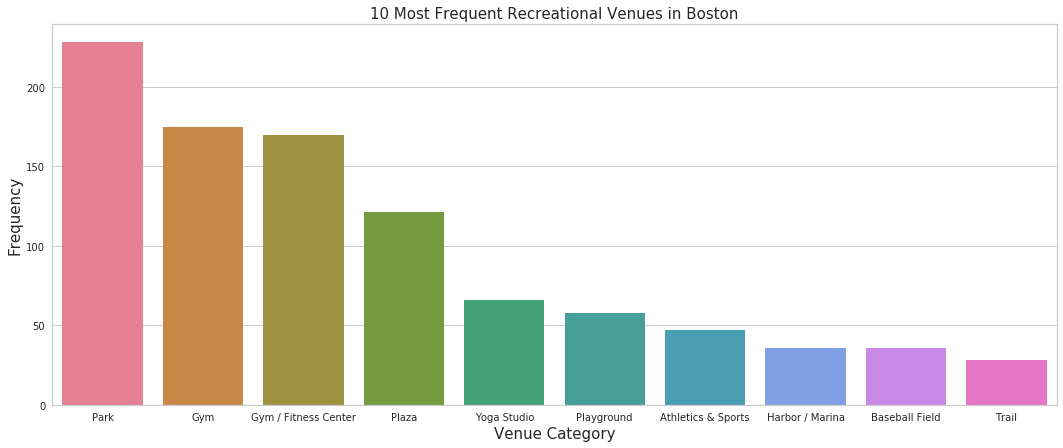

In [29]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Neighborhood",  palette="husl",saturation = 0.75, data=mostpop)
sns.set_context("paper")
s.set_xticklabels(s.get_xticklabels())
plt.title('10 Most Frequent Recreational Venues in Boston', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [30]:
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood names back to dataframe
boston_onehot.rename({"Neighborhood": "Neighborhood Category"}, axis='columns', inplace=True)
boston_onehot['Neighborhood'] = boston_venues['Neighborhood']


# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1] ]+ list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bowling Green,Boxing Gym,Campground,Climbing Gym,Cycle Studio,...,State / Provincial Park,Surf Spot,Tennis Court,Track,Trail,Tree,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Allston,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allston,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bowling Green,Boxing Gym,Campground,Climbing Gym,Cycle Studio,...,State / Provincial Park,Surf Spot,Tennis Court,Track,Trail,Tree,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,Allston,0.131579,0.026316,0.000000,0.000000,0.00,0.000000,0.026316,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.026316,0.078947
1,Back Bay,0.040000,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.000000,0.000000,0.050000,0.000000,0.00,0.00,0.010000,0.080000
2,Bay Village,0.050000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.050000
3,Beacon Hill,0.030000,0.030000,0.010000,0.000000,0.01,0.010000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.010000,0.030000,0.000000,0.00,0.00,0.000000,0.050000
4,Brighton,0.090909,0.045455,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.090909,0.000000,0.00,0.00,0.000000,0.045455
5,Charlestown,0.038462,0.019231,0.019231,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.019231,0.019231,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.096154
6,Chinatown,0.020000,0.020000,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.040000
7,Dorchester,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.111111,0.000000,0.00,0.00,0.000000,0.111111
8,Downtown,0.020000,0.030000,0.010000,0.000000,0.01,0.000000,0.000000,0.010000,0.030000,...,0.00000,0.000000,0.010000,0.010000,0.030000,0.000000,0.00,0.01,0.000000,0.030000
9,East Boston,0.032258,0.032258,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.032258


In [34]:
def plotTop5(neighborhood, xcoord, ycoord,hood):
    fig = plt.figure(figsize=(5,3))
    sns.despine(left=True)
    s=sns.barplot(x=xcoord, y=ycoord, data=neighborhood, orient = 'v')
    s.set_xticklabels(s.get_xticklabels(),rotation=40, fontsize = 10)
    plt.title('Top 5 Recreation Venues in {}, Boston'.format(hood), fontsize=12)
    plt.xlabel("Venue Category", fontsize=12)
    plt.ylabel ("Frequency", fontsize=12)
    plt.show()

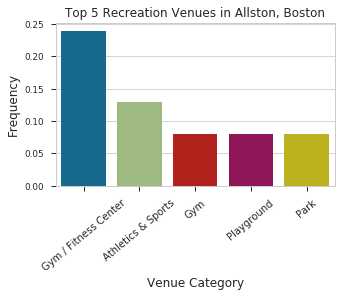

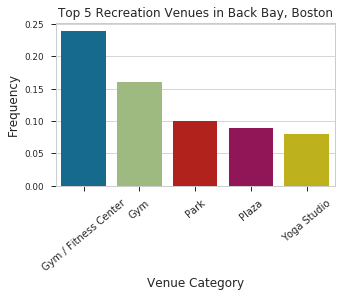

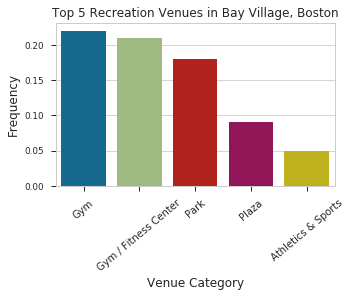

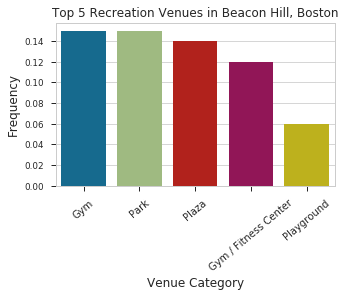

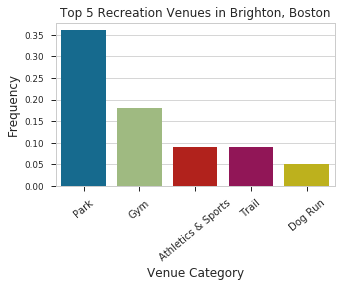

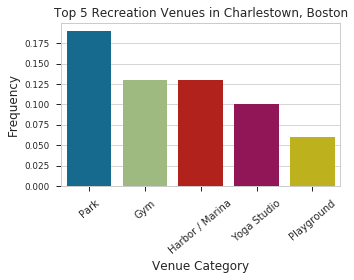

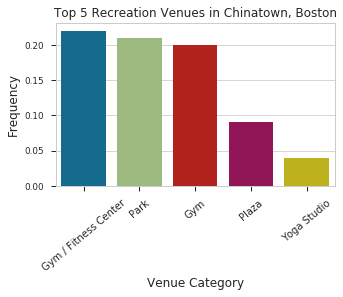

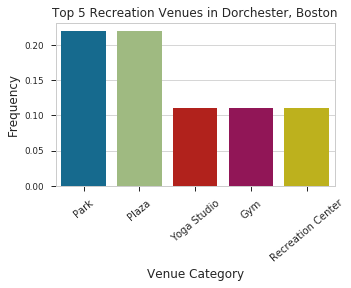

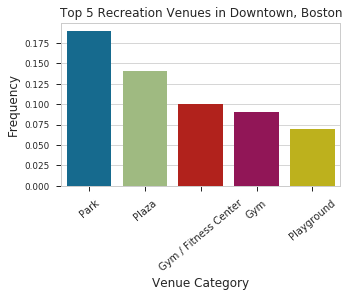

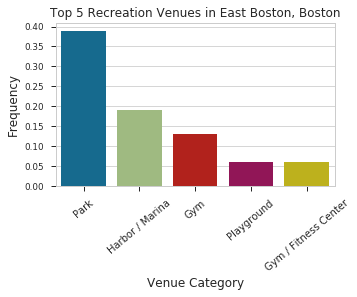

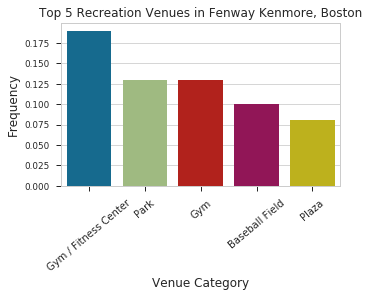

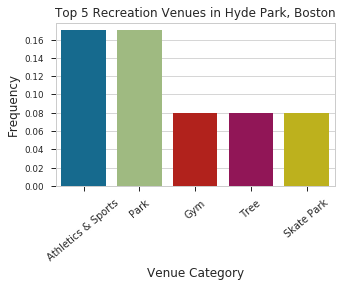

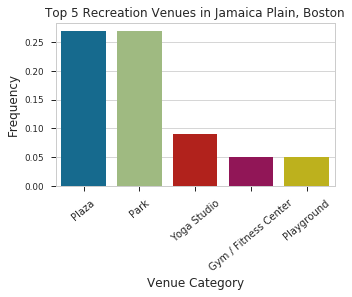

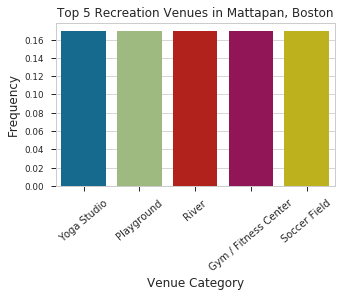

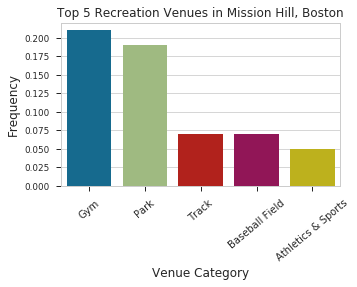

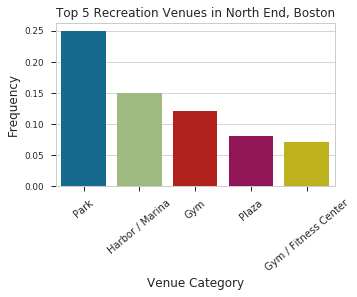

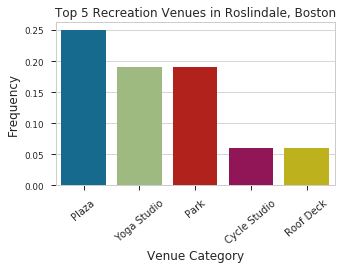

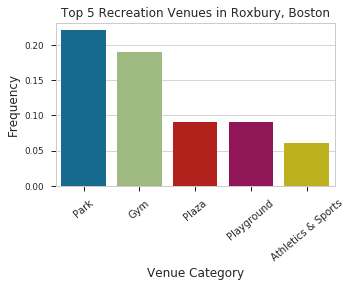

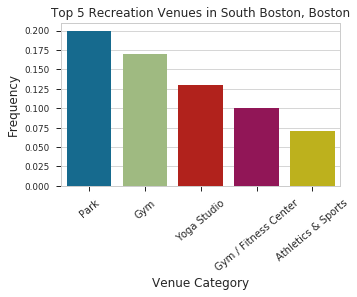

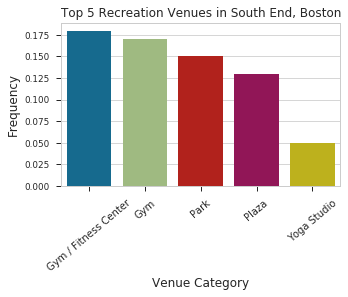

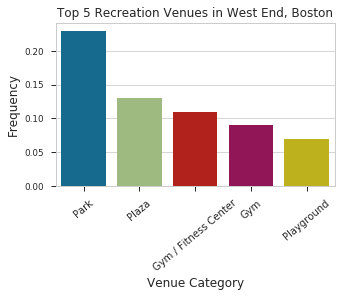

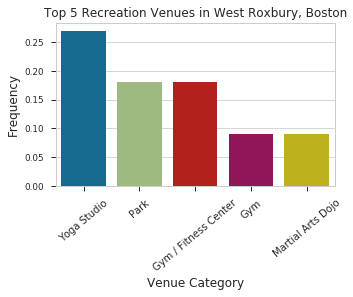

In [35]:
num_top_venues = 5
subplots = 22
for hood in boston_grouped['Neighborhood']:
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    temp = temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp = temp[0:5]
    plotTop5(temp, 'Venue' , 'Frequency', hood)

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Campground,Weight Loss Center
1,Back Bay,Gym / Fitness Center,Gym,Park,Plaza,Yoga Studio,Trail,Playground,Athletics & Sports,Sculpture Garden,Cycle Studio
2,Bay Village,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Baseball Field,Dog Run
3,Beacon Hill,Gym,Park,Plaza,Gym / Fitness Center,Playground,Yoga Studio,Sculpture Garden,Baseball Field,Cycle Studio,Scenic Lookout
4,Brighton,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio


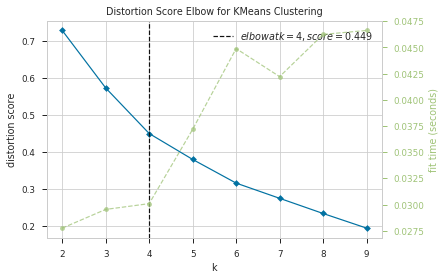

In [39]:
#elbow method to determine best cluster numbers
model = KMeans()
boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(boston_grouped_clustering)        # Fit the data to the visualizer
visualizer.show() 

In [40]:
kclusters = 4

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 3, 3, 1, 0, 1, 3], dtype=int32)

In [42]:
# add clustering labels

#uncomment this line if running block again
#neighborhoods_venues_sorted.drop(columns =['Cluster Labels'], axis = 1, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = df

# merge boston_grouped with df to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,42.355434,-71.132127,1,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Campground,Weight Loss Center
1,Back Bay,42.350707,-71.079730,1,Gym / Fitness Center,Gym,Park,Plaza,Yoga Studio,Trail,Playground,Athletics & Sports,Sculpture Garden,Cycle Studio
2,Bay Village,42.350011,-71.066948,1,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Baseball Field,Dog Run
3,Beacon Hill,42.358708,-71.067829,1,Gym,Park,Plaza,Gym / Fitness Center,Playground,Yoga Studio,Sculpture Garden,Baseball Field,Cycle Studio,Scenic Lookout
4,Brighton,42.350097,-71.156442,3,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio
5,Charlestown,42.377875,-71.061996,3,Park,Gym,Harbor / Marina,Yoga Studio,Playground,Skating Rink,Gym / Fitness Center,National Park,Pool,Athletics & Sports
6,Chinatown,42.351329,-71.062623,1,Gym / Fitness Center,Park,Gym,Plaza,Yoga Studio,Playground,Cycle Studio,Scenic Lookout,Baseball Field,Pilates Studio
7,Dorchester,42.297320,-71.074495,0,Park,Plaza,Golf Course,Recreation Center,Gym,Yoga Studio,Trail,Bowling Green,Gym / Fitness Center,Martial Arts Dojo
8,Downtown,42.362918,-71.068737,1,Park,Plaza,Gym / Fitness Center,Gym,Playground,Scenic Lookout,Yoga Studio,Baseball Field,Cycle Studio,Trail
9,East Boston,42.375097,-71.039217,3,Park,Harbor / Marina,Gym,Gym / Fitness Center,Playground,Yoga Studio,Sports Club,Baseball Field,Skate Park,Athletics & Sports


In [56]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+5))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], 
                                  boston_merged['Longitude'], 
                                  boston_merged['Neighborhood'], 
                                  boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [57]:
boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Campground,Weight Loss Center
1,Back Bay,Gym / Fitness Center,Gym,Park,Plaza,Yoga Studio,Trail,Playground,Athletics & Sports,Sculpture Garden,Cycle Studio
2,Bay Village,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Baseball Field,Dog Run
3,Beacon Hill,Gym,Park,Plaza,Gym / Fitness Center,Playground,Yoga Studio,Sculpture Garden,Baseball Field,Cycle Studio,Scenic Lookout
6,Chinatown,Gym / Fitness Center,Park,Gym,Plaza,Yoga Studio,Playground,Cycle Studio,Scenic Lookout,Baseball Field,Pilates Studio
8,Downtown,Park,Plaza,Gym / Fitness Center,Gym,Playground,Scenic Lookout,Yoga Studio,Baseball Field,Cycle Studio,Trail
10,Fenway Kenmore,Gym / Fitness Center,Gym,Park,Baseball Field,Plaza,Athletics & Sports,Trail,Sculpture Garden,Garden,Pool
11,Hyde Park,Athletics & Sports,Park,Skate Park,Baseball Field,Gym,Gym / Fitness Center,Plaza,Recreation Center,Yoga Studio,Tree
14,Mission Hill,Gym,Park,Baseball Field,Track,Yoga Studio,Scenic Lookout,Gym / Fitness Center,Playground,Plaza,Athletics & Sports
17,Roxbury,Park,Gym,Playground,Plaza,Athletics & Sports,Skating Rink,Baseball Field,Track,Basketball Court,Gym / Fitness Center


In [58]:
boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Dorchester,Park,Plaza,Golf Course,Recreation Center,Gym,Yoga Studio,Trail,Bowling Green,Gym / Fitness Center,Martial Arts Dojo
12,Jamaica Plain,Plaza,Park,Yoga Studio,Cycle Studio,Gym,Gym / Fitness Center,Harbor / Marina,Lake,Playground,Pedestrian Plaza
16,Roslindale,Plaza,Yoga Studio,Park,Trail,Pool,Cycle Studio,Gym / Fitness Center,Roof Deck,Scenic Lookout,Golf Course


In [59]:
boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Mattapan,Yoga Studio,Playground,Plaza,River,Gym / Fitness Center,Soccer Field,Garden,Lake,Hockey Rink,Hockey Field


In [60]:
boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Brighton,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio
5,Charlestown,Park,Gym,Harbor / Marina,Yoga Studio,Playground,Skating Rink,Gym / Fitness Center,National Park,Pool,Athletics & Sports
9,East Boston,Park,Harbor / Marina,Gym,Gym / Fitness Center,Playground,Yoga Studio,Sports Club,Baseball Field,Skate Park,Athletics & Sports
15,North End,Park,Harbor / Marina,Gym,Plaza,Gym / Fitness Center,Sculpture Garden,Playground,Yoga Studio,Basketball Court,Cycle Studio
